# A U-Net for Drosophila wing segmentation

### Loading the pickled datasets

In [10]:
# load
import pickle

timeRange=range(0,200,10)
xRange = range(500,800,100)
yRange = range(1000,1300,100)

fname = "pickles/dataset_xr_range(500, 800, 100)_yr_range(1000, 1300, 100)_tr_range(0, 200, 10)"
f = open(fname,'rb')
rawListArray, gtListArray = pickle.load(f)
f.close()
range(500,800,100)

ValueError: unsupported pickle protocol: 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,20

def plotSome(arr,indices = [], num = 5):
    if (arr.ndim != 3):
        raise ValueError("what is arr?")
    elif(arr.shape[0] < num):
        raise ValueError("two many elements, choose a smaller num")
    else:
        if ( len(indices) == num):
            cho = arr[indices]
        else:
            indices = np.random.choice(arr.shape[0],num, replace=False)
            cho = arr[indices]
        w = 5
        h = num//w + 1*(num%w!=0)
        for i in range(w):
            for j in range(h):
                
                plt.subplot(h,w,i*h+j+1)
                plt.imshow(cho[i*h+j])
                plt.axis("off")
    return indices
    

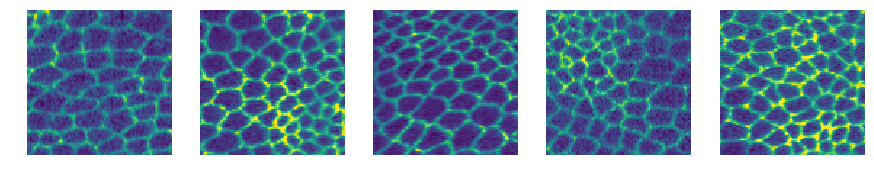

In [3]:
ind = plotSome(rawListArray, num=5)

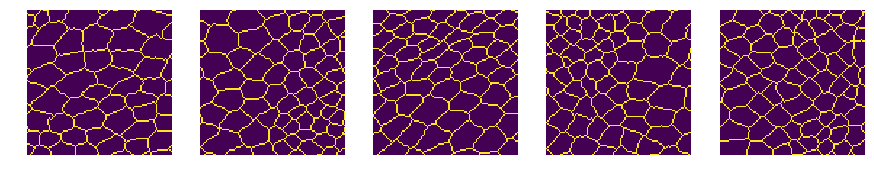

In [4]:
plotSome(gtListArray, indices=ind, num=5) ;

In [5]:
rawListArray.shape

(900, 100, 100)

In [6]:
big_patch_set = np.asarray(rawListArray, dtype = np.float32)
big_label_set = np.asarray(gtListArray, dtype = np.float32)

In [7]:
def augment(patch):
    alist = []
    alist.append(patch)
    for i in range(1,4):
        alist.append(np.rot90(patch,i))
        
    pfl = patch[:,::-1]
    alist.append(pfl)
    for i in range(1,4):
        alist.append(np.rot90(pfl,i))
    return alist

In [8]:
def generate_augmented_set(init_set):
    print("Initial set size: %dx%dx%d" % init_set.shape)
    augmented_set = []
    for p in init_set:
        augmented_set.append(augment(p))

    augmented_set = np.concatenate(augmented_set)
    print("Final set size: %dx%dx%d" % augmented_set.shape)
    return augmented_set

In [9]:
# X = np.concatenate([_x  for _x in augment_iter(big_patch_set) ], axis = 0)
# Y = np.concatenate([_y  for _y in augment_iter(big_label_set) ], axis = 0)


validation_split = 10
threshold = int(np.floor(0.01*validation_split*(len(rawListArray))))

ind = np.arange(len(rawListArray))
np.random.shuffle(ind)

X_train = rawListArray[ind[:-threshold]]
Y_train = gtListArray[ind[:-threshold]]
X_test = rawListArray[ind[-threshold:]]
Y_test = gtListArray[ind[-threshold:]]

print("Augmenting training data...")
X_train = generate_augmented_set(X_train)
print("\n")
print("Augmenting training labels...")
Y_train = generate_augmented_set(Y_train)

print("\n")
print("Test split is: %dx%d" % (validation_split, 100-validation_split))
print("Final sizes:")
print("- training set: %d"% X_train.shape[0])
print("- test set: %d"% X_test.shape[0])

Augmenting training data...
Initial set size: 810x100x100
Final set size: 6480x100x100


Augmenting training labels...
Initial set size: 810x100x100
Final set size: 6480x100x100


Test split is: 10x90
Final sizes:
- training set: 6480
- test set: 90


In [10]:
# converting to tensors with right dimensions

X_train = X_train[...,np.newaxis]
Y_train = Y_train[...,np.newaxis]
X_test = X_test[...,np.newaxis]
Y_test = Y_test[...,np.newaxis]

In [11]:
# sanity check
X_train.shape[1:]

(100, 100, 1)

## Building the model

In [12]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.layers import Dropout, Activation, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, SeparableConv2D
from keras.layers.merge import Concatenate, Add
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam
import keras.callbacks


def conv_block2(n_filter, n1, n2,
                activation="relu",
                border_mode="same",
                dropout=0.0,
                batch_norm=False,
                init="glorot_uniform",
                ):
    def _func(lay):
        s = Conv2D(n_filter, (n1, n2), padding=border_mode, kernel_initializer=init)(lay)
        if batch_norm:
            s = BatchNormalization()(s)
        s = Activation(activation)(s)
        if dropout > 0:
            s = Dropout(dropout)(s)
        return s

    return _func



def unet_block(n_depth=2, n_filter_base=16, n_row=3, n_col=3, n_conv_per_depth=2,
               activation="relu",
               batch_norm=False,
               dropout=0.0,
               last_activation=None):
    """"""

    if last_activation is None:
        last_activation = activation

    if K.image_dim_ordering() == "tf":
        channel_axis = -1
    else:
        channel_axis = 1


    def _func(input):
        skip_layers = []
        layer = input

        # down ...
        for n in range(n_depth):
            for i in range(n_conv_per_depth):
                layer = conv_block2(n_filter_base * 2 ** n, n_row, n_col,
                                    dropout=dropout,
                                    activation=activation,
                                    batch_norm=batch_norm)(layer)
            skip_layers.append(layer)
            layer = MaxPooling2D((2, 2))(layer)


        # middle
        for i in range(n_conv_per_depth - 1):
            layer = conv_block2(n_filter_base * 2 ** n_depth, n_row, n_col,
                                dropout=dropout,
                                activation=activation,
                                batch_norm=batch_norm)(layer)

        layer = conv_block2(n_filter_base * 2 ** (n_depth - 1), n_row, n_col,
                            dropout=dropout,
                            activation=activation,
                            batch_norm=batch_norm)(layer)

        # ...and up with skip layers
        for n in reversed(range(n_depth)):
            layer = Concatenate(axis = channel_axis)([UpSampling2D((2, 2))(layer), skip_layers[n]])
            for i in range(n_conv_per_depth - 1):
                layer = conv_block2(n_filter_base * 2 ** n, n_row, n_col,
                                    dropout=dropout,
                                    activation=activation,
                                    batch_norm=batch_norm)(layer)

            layer = conv_block2(n_filter_base * 2 ** max(0, n - 1), n_row, n_col,
                                dropout=dropout,
                                activation=activation if n > 0 else last_activation,
                                batch_norm=batch_norm)(layer)

        return layer

    return _func


# def my_binary_crossentropy(weights =(1., 1.)):
#     def _func(y_true, y_pred):
#         return -(weights[0] * K.mean((1-y_true)*K.log((1-y_pred)+K.epsilon())) +
#                  weights[1] * K.mean(y_true*K.log(y_pred+K.epsilon())))
#     return _func


def my_binary_crossentropy(weights =(1., 1.)):
    def _func(y_true, y_pred):
        return -(weights[0] * K.mean((1-y_true)*K.log((1-y_pred)+K.epsilon())) +
                 weights[1] * K.mean(y_true*K.log(y_pred+K.epsilon())))
    return _func

def my_binary_crossentropy_mod(weights =(1., 1.)):
    def _func(y_true, y_pred):
        return -(weights[0] * K.mean(K.cast(K.greater(0.25, y_true),dtype='float32')*K.log((1-y_pred)+K.epsilon())) +
                 weights[1] * K.mean(K.cast(K.greater(y_true,0.25),dtype='float32')*K.log(y_pred +K.epsilon())))
    return _func

def build_model_unet(input_shape, dropout=.2):
    input = Input(input_shape)

    unet = unet_block(2, 8, 3, 3, activation="relu")(input)
    final = Conv2D(1, (1, 1), activation='sigmoid')(unet)

    model = Model(inputs=input, outputs=final)

    return model


Using TensorFlow backend.


In [13]:
def acc1(y_true, y_pred):
   
   
    nom = K.mean(K.cast(K.cast(K.equal(K.round(y_pred),y_true), dtype='float32')*K.cast(K.equal(y_true,1),dtype='float32'),dtype='float32'))
    denom = K.mean(y_true)
#     nom = K.cast(nom, dtype='float32')
#     denom =  K.cast(denom, dtype='float32')
    return nom/denom
#     return K.shape(y_true)[0]



def acc0(y_true, y_pred):
    
    nom = K.mean(K.cast(K.cast(K.equal(K.round(y_pred),y_true), dtype='float32')*K.cast(K.equal(y_true,0),dtype='float32'),dtype='float32'))
    denom = K.mean(K.cast(K.equal(y_true,0),dtype='float32'))
#     nom = K.cast(nom, dtype='float32')
#     denom =  K.cast(denom, dtype='float32')
    return nom/denom

In [14]:
def acc1_mod(y_true, y_pred):
   
   
    nom = K.mean(K.cast(K.cast(K.greater(0.05,K.abs(y_pred-y_true)), dtype='float32')*K.cast(K.greater(y_true,0.2),dtype='float32'),dtype='float32'))
    denom = K.mean(K.cast(K.greater(y_true,0.2),dtype='float32'))
#     nom = K.cast(nom, dtype='float32')
#     denom =  K.cast(denom, dtype='float32')
    return nom/denom
#     return K.shape(y_true)[0]



def acc0_mod(y_true, y_pred):
    
    nom = K.mean(K.cast(K.cast(K.equal(K.round(y_pred),y_true), dtype='float32')*K.cast(K.equal(y_true,0),dtype='float32'),dtype='float32'))
    denom = K.mean(K.cast(K.equal(y_true,0),dtype='float32'))
#     nom = K.cast(nom, dtype='float32')
#     denom =  K.cast(denom, dtype='float32')
    return nom/denom


In [15]:
# model = build_model_unet(X_train.shape[1:], dropout = 0.2)
model = build_model_unet((None,None,1), dropout = 0.2)

# model.summary();


In [16]:
import os

batch_sizes = [50]
dropouts = [0.0]
arch = "_2_8_3_3"
tr_size = "_"+str(X_train.shape[0])
lr = 0.004
rate_decay=0.0
i=0

for bs in batch_sizes:
    for do in dropouts:
        tb_name = './logs/bs_'+str(bs)+'_drop_'+str(do)+"_arch_"+arch+"_trs_"+tr_size+"_"+"lr_"+\
                                                                    str(lr)+"_ld_"+str(rate_decay)+str(i)
        while(os.path.isdir(tb_name)):
            i+=1
            tb_name = './logs/bs_'+str(bs)+'_drop_'+str(do)+"_arch_"+arch+"_trs_"+tr_size+"_"+"lr_"+\
                                                                        str(lr)+"_ld_"+str(rate_decay)+str(i)
            
#         cb = keras.callbacks.TensorBoard(log_dir=tb_name)
        model = build_model_unet((None,None,1), dropout = do)
        model.compile(optimizer=Adam(lr=lr, decay=rate_decay), loss=my_binary_crossentropy(weights=(1.0,10.)), metrics = ['accuracy', acc1, acc0])
#         hist = model.fit(X_train,Y_train, epochs=40, batch_size=bs, validation_split=0.2, callbacks=[cb])
        hist = model.fit(X_train,Y_train, epochs=5, batch_size=bs, validation_split=0.2)

# hist = model.fit(X_train,Y_train, epochs=30, batch_size=200)

Train on 5184 samples, validate on 1296 samples
Epoch 1/5
5184/5184 [==============================] - 10s - loss: 0.6270 - acc: 0.7835 - acc1: 0.9414 - acc0: 0.7637 - val_loss: 0.3738 - val_acc: 0.8930 - val_acc1: 0.9711 - val_acc0: 0.8831
Epoch 2/5
5184/5184 [==============================] - 7s - loss: 0.3261 - acc: 0.9104 - acc1: 0.9715 - acc0: 0.9027 - val_loss: 0.3247 - val_acc: 0.9030 - val_acc1: 0.9789 - val_acc0: 0.8934
Epoch 3/5
5184/5184 [==============================] - 7s - loss: 0.2962 - acc: 0.9202 - acc1: 0.9725 - acc0: 0.9136 - val_loss: 0.2977 - val_acc: 0.9182 - val_acc1: 0.9738 - val_acc0: 0.9112
Epoch 4/5
5184/5184 [==============================] - 6s - loss: 0.2832 - acc: 0.9243 - acc1: 0.9729 - acc0: 0.9182 - val_loss: 0.2976 - val_acc: 0.9153 - val_acc1: 0.9766 - val_acc0: 0.9076
Epoch 5/5
5184/5184 [==============================] - 7s - loss: 0.2738 - acc: 0.9271 - acc1: 0.9736 - acc0: 0.9212 - val_loss: 0.2827 - val_acc: 0.9296 - val_acc1: 0.9671 - val_acc0

In [17]:
Y_pred = model.predict(X_test)

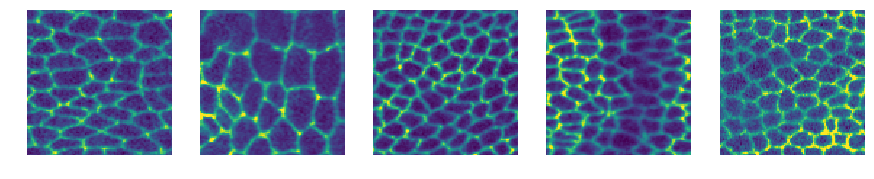

In [18]:
idc = plotSome(X_test[:,:,:,0], num=5)

In [19]:
# plotSome(Y_test[:,:,:,0], indices=idc, num=5);

array([33, 67, 79, 36, 24])

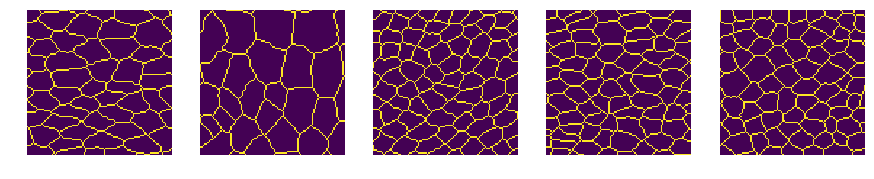

In [20]:
plotSome(Y_test[:,:,:,0]>0.2, indices=idc, num=5)

array([33, 67, 79, 36, 24])

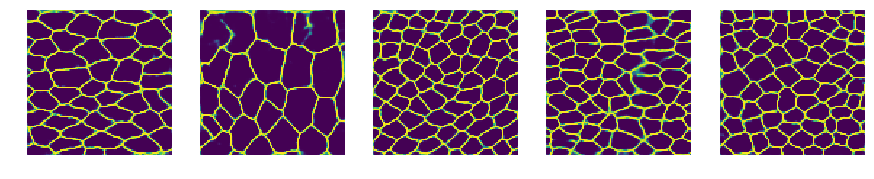

In [21]:
plotSome(Y_pred[:,:,:,0], indices=idc, num=5)

In [22]:
from PIL import Image
import numpy as np

def tif2array(image_path):
    ## Imports an arbitrary .tif image and creates a numpy array with the pixel-values
    im = Image.open(image_path)
    return np.array(im.getdata()).reshape(im.size[::-1])
    
def load_ground_truth(image_path = "./data/groundTruth.tif"):
    ## Imports a .tif image with the ground truth (drosophila wing) 
    ## and creates a numpy array with the pixel-values
    
    im = Image.open(image_path).convert("1")
    return np.array(im.getdata()).reshape(im.size[::-1])
    
def load_raw_data(image_path = "./data/rawData.tif"):
    ## Imports a .tif image with the raw data (drosophila wing)
    ## and creates a numpy array with the pixel-values
    im = Image.open(image_path)
    return np.array(im.getdata()).reshape(im.size[::-1])
    
def load_crop(image_path="./data/rawData.tif", origin=(400,400), length=100, width=100):
    ## Imports an arbitrary .tif image region
    ## and creates a numpy array with the pixel-values

    im = Image.open(image_path)
    return np.array(im.getdata().convert("1")).reshape(im.size[::-1])[origin[0]:origin[0]+length,origin[1]:origin[1]+width]


In [23]:
def normalize(img):
    if (not (type(img)is np.ndarray)):
        print("this is not an array")
        return
    elif (img.ndim !=2):
        return
        print("not a 2d image")
    else:
        minVal = img.min()
        
        return (img-minVal)/(img.max()-minVal)

In [24]:
import os, time, sys
from matplotlib import image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# x: 1000:1500 ---> vertical
# y: 600:1000 --->horizontal
# upd: 800 for y is too much
# flip the numbers! wrong now...

listOfDir = ['MT_spleOE_25deg_170209', 'MTpk30_25deg_160409', 'MTpk30_25deg_160628', 
             'MTpk30_25deg_160629', 'MTstbm_25deg_151125', 'MTstbm_25deg_151128', 
             'MTstbm6_25deg_141211', 'WT_25deg_160330', 'WT_25deg_160402',
             'WT_25deg_160403', 'WT_25deg_160413', 'WTng4_25deg_161206']

subListOfDir =listOfDir[:1]



timeRange=range(0,200,1)
xSize = 100
ySize = 100
dX =100
dY = 100
xRange = range(500,800,dX)
yRange = range(1000,1300,dY)

rawList = []
gtList = []

dataDir = "D:\\franz_listed_timelapses\\"

for d in subListOfDir:
    currDir = dataDir+d
    print("--> segmenting: " + d )
    if (os.path.isdir(currDir)):
        for t in timeRange:
            suffix = ''
            if (t<10):
                suffix = "00" + str(t)
            elif(t<100):
                suffix = "0"+str(t)
            else:
                suffix = str(t)
            print(suffix + ":")
            
            pathToFiles = currDir + "\\Segmentation\\"+d+"_"+suffix+"\\"  
            img_raw_path = pathToFiles + "original.png"
            
            raw = normalize(image.imread(img_raw_path))
            xx,yy = raw.shape
            print("img size: %dx%d" %(xx,yy ))
            delx = 0
            dely= 0
            while((xx-delx)%4!=0):
                delx+=1
            while((yy-dely)%4!=0):
                dely+=1
            raw_cropped = raw[:xx-delx,:yy-dely]
            print("cropped size: %dx%d"%raw_cropped.shape)
            raw_tens = raw_cropped[np.newaxis, ..., np.newaxis]
            pr = model.predict(raw_tens)
            pr_img_cropped = pr[0,:,:,0]
            if (delx != 0):
                buffx = np.zeros((delx,yy-dely))
                pr_img_cropped = np.concatenate((pr_img_cropped,buffx))
            if (dely!=0):
                buffy = np.zeros((xx,dely))
                pr_img_cropped = np.concatenate((pr_img_cropped,buffy),axis=1)
                
            pr_restored = pr_img_cropped
            print("restored size: %dx%d" %pr_restored.shape)
            image.imsave(pathToFiles+"unet.png", pr_restored, cmap="gray")
            
    else:
        print("--! skipping: " + d + ", directory not found")



--> segmenting: MT_spleOE_25deg_170209
000:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
001:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
002:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
003:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
004:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
005:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
006:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
007:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
008:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
009:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
010:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
011:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396
012:
img size: 1695x3396
cropped size: 1692x3396
restored size: 1695x3396

KeyboardInterrupt: 

In [ ]:
raw.shape
buff = 0.1*np.random.randn(1,raw.shape[1])
raw_conc = np.concatenate((raw,buff))
raw_tens = raw_conc[np.newaxis,...,np.newaxis]

In [ ]:
raw_conc.shape, raw.shape, raw_tens.shape

In [ ]:
pr = model.predict(raw_tens[:,0:1780,0:3708,:], verbose=1)

In [ ]:
plt.imshow(pr[0,:,:,0], cmap="gray")

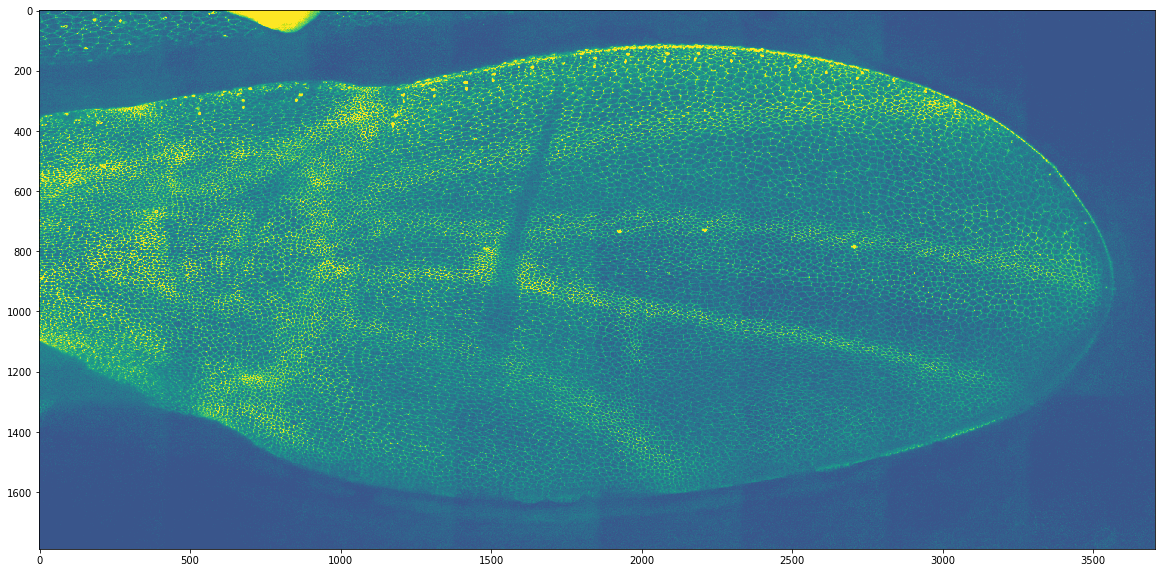

In [67]:
plt.imshow(raw_conc)

In [288]:
pr.shape

(1, 1700, 3396, 1)

In [144]:
raw_conc.min()

0.0

In [145]:
raw_conc.max()

1.0

In [148]:
np.isnan(raw_conc).any()

False

In [158]:
raw_conc.shape

(1700, 3396)

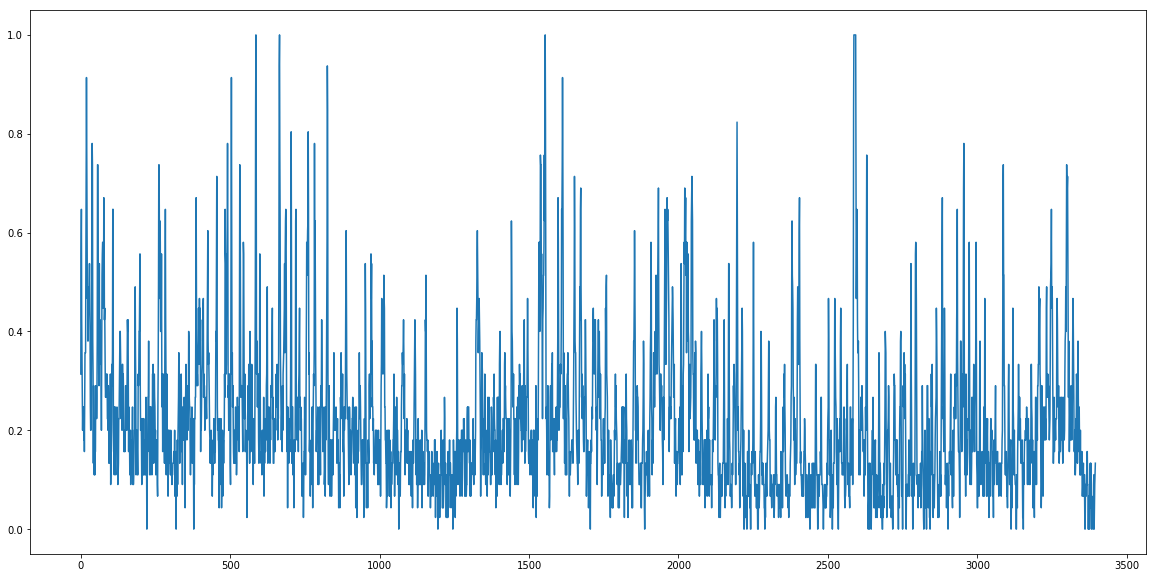

In [165]:
plt.plot(raw_conc[900,:])

In [25]:
model.save("unet.h5")

In [40]:
model_loaded = keras.models.load_model("unet.h5", custom_objects={"_func":my_binary_crossentropy((1,10)), \
                                                                  "acc1":acc1, "acc0":acc0})

In [44]:
p = model_loaded.predict(X_test)

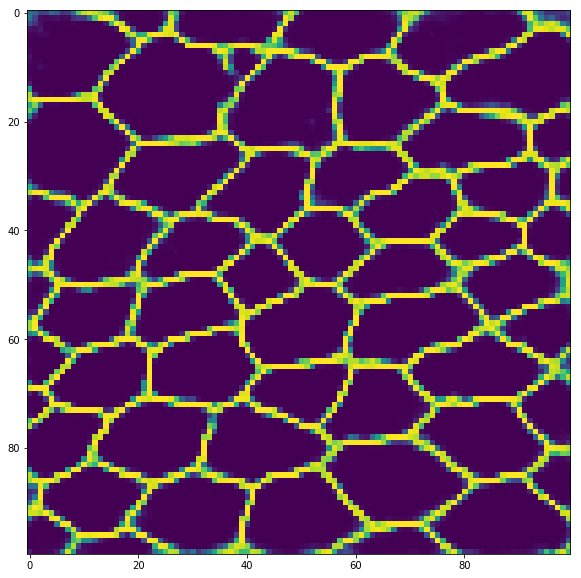

In [45]:
plt.imshow(p[0,:,:,0])